When a new sequence comes in, we will need to be able to convert it to its interpolated reference form.

In [16]:
from bokeh.charts import Bar, BoxPlot
from bokeh.io import output_notebook
from bokeh.resources import INLINE
from bokeh.embed import components
from bokeh.models import HoverTool, ResetTool
from bokeh.plotting import figure, show
output_notebook()

Loading BokehJS ...

In [2]:
from Bio.SeqRecord import SeqRecord
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import PchipInterpolator
from gsdash.molecular_weight import molecular_weights

from gsdash.sequence_transformer import to_numeric_rep, standardize_sequence

%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [3]:
from Bio import SeqIO

len(SeqIO.read('../data/hiv-protease-consensus.fasta', 'fasta'))

99

In [4]:
ref_sequence = 'PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNIIGRNLLTQIGCTLNF'
new_sequence1 = 'PQITLNQMTLVTIPIGGDLKEALLKTGADFTVLEEMNLPGDMKPKMIGGIGGFIKVRQYDQILIEICGRKAIGTVLVGPTPVNIIGRNLLTQVGCTLNFP'
new_sequence2 = 'PQITLWQRPLVTIKIGGQLKEALLKTGADDTVLEEMNLPGRWKPKMIRGIGGFIKMRQYDKILIEICGHQAIGTVLVGPTPRNIIGDNLLTIIGCTLN'

In [5]:
ref = standardize_sequence(to_numeric_rep(ref_sequence, 'mw'), 'protease')

In [6]:
new1 = standardize_sequence(to_numeric_rep(new_sequence1, 'mw'), 'protease')

In [7]:
new2 = standardize_sequence(to_numeric_rep(new_sequence2, 'mw'), 'protease')

In [8]:
ref.size == new1.size

True

In [9]:
new1.size == new2.size

True

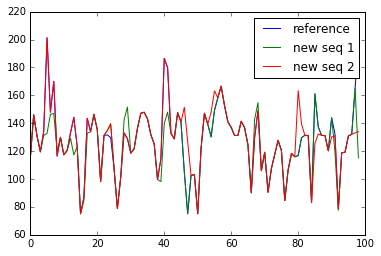

In [10]:
plt.plot(ref, label='reference')
plt.plot(new1, label='new seq 1')
plt.plot(new2, label='new seq 2')
plt.legend()

In [11]:
drugs = ['FPV', 'ATV', 'IDV', 'LPV', 'NFV', 'SQV', 'TPV', 'DRV',]

def pred_intervals(model, datum, percentile=95):
    """
    Computes prediction intervals for a given model and single datapoint.
    """
    preds = np.zeros(len(model.estimators_))

    for i, est in enumerate(model.estimators_):
        preds[i] = est.predict(datum.reshape(1, -1))[0]

    # lowbound = np.percentile(preds, (100-percentile) / 2.0)
    # uppbound = np.percentile(preds, 100 - (100-percentile) / 2.0)

    return preds


In [12]:
from sklearn.externals import joblib
preds = dict()
for drug in drugs[0:2]:
    print(drug)
    mdl = joblib.load("../models/base/{drug}/{drug}.pkl".format(drug=drug))
    # pred = mdl.predict(seq)[0]
    pred = pred_intervals(mdl, new1)
    # preds.append(dict(drug=drug, pred=pred))
    preds[drug] = pred
    # preds['log10(DR)'].append(pred)
    # preds['lowbound'].append(lowbound)
    # preds['uppbound'].append(uppbound)
    print(pred)


FPV
[ 1.24303805  1.24303805 -0.09691001 ...,  0.61278386  0.04139269
  0.8920946 ]
ATV
[ 1.18184359 -0.09691001  1.07918125 ...,  0.07918125  0.49136169  0.        ]


In [13]:
pd.DataFrame(preds).head()

,ATV,FPV
0,1.181844,1.243038
1,-0.096910,1.243038
2,1.079181,-0.096910
3,0.146128,1.243038
4,0.079181,1.531479


In [14]:
hover = HoverTool()
hover.tooltips = [
    # ("(x, y)", "($x, $y)"),
    ("Drug", "@drug"),
    ("Resistance", "@height")
]
TOOLS = [hover, ResetTool()]

# b = BoxPlot(data=preds, values='log10(DR)', label='drug', title="protease drug resistance",
#             plot_width=600, plot_height=400, legend=False, tools=TOOLS)
b = BoxPlot(data=pd.DataFrame(preds))
show(b)

In [15]:
p = figure()
p.circle([1, 2, 3], [1,2,3])
show(p)